In [ ]:
!pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
import json

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model, Sequential, regularizers
from tensorflow.keras.layers import concatenate,TimeDistributed, Concatenate, GRU, Activation, SpatialDropout2D, Dropout, Flatten,SeparableConv1D, Dense, SimpleRNN, LSTM, Conv1D, Reshape,MaxPooling1D, Conv2D, Reshape,MaxPooling2D, Permute,Bidirectional, BatchNormalization, DepthwiseConv2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,Callback#training callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import models
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np


In [102]:
data_path = '/content/drive/MyDrive/text-classifier/data-set-rows.json'

with open(data_path) as data_file:
  data_text = data_file.read()  
  # убираем BOM-символ из json файла
  data = json.loads(data_text.lstrip('\ufeff'))
  df = pd.DataFrame(data)

print('Total rows:', len(df))
print('Duplicates:', sum(df["TextLine"].duplicated()))

Total rows: 2043
Duplicates: 415


drop duplicates

In [103]:
df = df[~df["TextLine"].duplicated()]
print('Deduplicated rows:', len(df))



Deduplicated rows: 1628


In [104]:
#print(df.info)
print(df.shape)
print(df.columns.values)
print(df.head(5))

(1628, 2)
['TextLine' 'Parameters']
                                            TextLine Parameters
0                             пневмония, КТ-2, ДН 0         [0]
2  дыхание, першение в горле, головная боль, одыш...        [0]
3  Жалобы: слабость общая умеренная, сухой со сви...        [0]
4  Жалобы: слабость общая умеренная, сухой, одышк...        [0]
5  Жалобы: слабость общая умеренная, сухой, одышк...        [0]


In [105]:
#print values
data_with_two_params = list(filter(lambda x: len(x) > 1, df['Parameters']))
data_with_one_params = list(filter(lambda x: len(x) > 0, df['Parameters']))
data_with_zero_params = list(filter(lambda x: len(x) == 0, df['Parameters']))
print(len(data_with_two_params))
print(len(data_with_one_params))
print(len(data_with_zero_params))

0
994
634


In [106]:
#preprocess the data
import re
to_exclude = '»«$&()*+-/<=>@[\\]^_`{|}~\t\n'#excluded symbols
to_tokenize = '.,:!?";%#'#processed symbols

data_length = len(df.index)

for i in range(data_length):
    df.iloc[i]["TextLine"]=re.sub(r'(['+to_tokenize+'])', r' \1 ', df.iloc[i]['TextLine'])

    if i%100==0:
      print(df.iloc[i])

TextLine        пневмония ,  КТ-2 ,  ДН 0 
Parameters                             [0]
Name: 0, dtype: object
TextLine      гемоглобина (MCHC) 310 . 00 г/л (323 . 00 - 35...
Parameters                                                  [1]
Name: 112, dtype: object
TextLine      Основной :  Коронавирусная инфекция ,  вызванн...
Parameters                                                   []
Name: 218, dtype: object
TextLine       Жалобы :  кашель малопродуктивный .  боль в н...
Parameters                                                   []
Name: 338, dtype: object
TextLine       Доступные и значимые данные лабораторных и ин...
Parameters                                                   []
Name: 446, dtype: object
TextLine      На протяжении обоих легких участки уплотнения ...
Parameters                                                  [0]
Name: 567, dtype: object
TextLine      Диагноз :  Основное заболевание Короновирусная...
Parameters                                                  [0

In [107]:
text_subframe = df["TextLine"]
max_len = 50
num_words = 6000

tokenizer_text = Tokenizer(num_words=num_words, filters=to_exclude, oov_token='UNK')

tokenizer_text.fit_on_texts(text_subframe)

tokenizer_text.word_index


{'UNK': 1,
 '.': 2,
 ',': 3,
 'в': 4,
 '00': 5,
 'л': 6,
 '0': 7,
 ':': 8,
 '%': 9,
 'на': 10,
 ';': 11,
 '3': 12,
 '1': 13,
 '10': 14,
 'мин': 15,
 '2': 16,
 'при': 17,
 'с': 18,
 '10е9': 19,
 'не': 20,
 '4': 21,
 'сатурация': 22,
 'одышка': 23,
 'ст': 24,
 '20': 25,
 '5': 26,
 'дыхание': 27,
 '50': 28,
 'хрипы': 29,
 '80': 30,
 'и': 31,
 '#': 32,
 '11': 33,
 'кислорода': 34,
 'чд': 35,
 'пневмония': 36,
 'дн': 37,
 'нет': 38,
 'г': 39,
 'мм': 40,
 '19': 41,
 'по': 42,
 '2021': 43,
 'лимфоциты': 44,
 'двусторонняя': 45,
 'фн': 46,
 '70': 47,
 '7': 48,
 'жалобы': 49,
 'дыхания': 50,
 '30': 51,
 'кислороде': 52,
 'нагрузке': 53,
 'воздухе': 54,
 'акте': 55,
 '12': 56,
 'во': 57,
 'кт': 58,
 '36': 59,
 'внебольничная': 60,
 '40': 61,
 'вспомогательная': 62,
 'участвует': 63,
 'мускулатура': 64,
 '90': 65,
 'отделы': 66,
 'все': 67,
 'проводится': 68,
 'от': 69,
 'вирусная': 70,
 'состояние': 71,
 '60': 72,
 '21': 73,
 'лейкоциты': 74,
 'увлажненном': 75,
 '8': 76,
 'сидя': 77,
 'инфекция

In [108]:
#create sequenses
sequences_text = tokenizer_text.texts_to_sequences(text_subframe)
print(text_subframe.iloc[814])
print(sequences_text[814])

maxlen = text_subframe.str.len().max()
print(maxlen)

 Дыхание ослаблено слева ,  ослаблено справа .  Хрипы отсутствуют .  Одышка при ФН .  В акте дыхания вспомогательная мускулатура не участвует .  ЧД 21  в мин .  Сатурация 98  %  сидя на О 2 терапии 7 л/мин  ,  на атмосферном воздухе 90  %  .  
[27, 211, 215, 3, 211, 156, 2, 29, 84, 2, 23, 17, 46, 2, 4, 55, 50, 62, 64, 20, 63, 2, 35, 73, 4, 15, 2, 22, 104, 9, 77, 10, 181, 16, 146, 48, 6, 15, 3, 10, 364, 54, 65, 9, 2]
4850


In [129]:
max_text_len = 300
sequences_padded = pad_sequences(sequences_text, maxlen=max_text_len, padding='post', truncating='post')

#params_data = df["Parameters"].apply(lambda x: [0] if x == [] else x)
params_data = df["Parameters"]

print(len(sequences_text[814]))
print(len(sequences_padded[814]))
print(type(params_data))

45
300
<class 'pandas.core.series.Series'>


In [130]:
test_split = 0.1

seq_train_df, seq_test_df, params_train_df, params_test_df = train_test_split(
    sequences_padded,
    params_data,
    test_size=test_split,
    shuffle=True
    #stratify=params_data.values
)

print("training set of sequences: ", len(seq_train_df))
print("test set of sequences:", len(seq_test_df))
print("training set of params", len(params_train_df))
print("test set of params", len(params_test_df))


training set of sequences:  1465
test set of sequences: 163
training set of params 1465
test set of params 163


In [131]:
#make lookup for train df
params_train = tf.ragged.constant(params_train_df)
lookup = tf.keras.layers.CategoryEncoding(num_tokens=2, output_mode="multi_hot")
#lookup.adapt(params_train)
#vocab = lookup.get_vocabulary()
params_train_binarized = lookup(params_train)

#make lookup for test df
params_test = tf.ragged.constant(params_test_df)
params_test_binarized = lookup(params_test)

#print(vocab)
print(params_test_binarized.shape)
print(params_train_binarized.shape)

(163, 2)
(1465, 2)


In [136]:
sample_label = params_data.iloc[29]
#sample_label = []
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")
#print(label_binarized.shape)

Original label: [1]
Label-binarized representation: [[0. 1.]]


In [137]:
print(seq_train_df)

[[525 310 146 ...   0   0   0]
 [138 249   8 ...   0   0   0]
 [ 27  68  57 ...   0   0   0]
 ...
 [ 56   2  14 ...   0   0   0]
 [361 401   3 ...   0   0   0]
 [ 26   2   7 ...   0   0   0]]


In [139]:

lstm_drop=0.1
input_shape = (seq_train_df.shape[1])
model_input = Input(shape=input_shape)
embedding = Embedding(num_words, 128) (model_input)
lstm = LSTM(129, dropout=lstm_drop, return_sequences=True) (embedding)
flat = Flatten()(lstm)
out = Dense(2, activation="sigmoid")(flat)
model = Model(model_input, out)
loss = 'binary_crossentropy'
optimizer = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
#optimizer = optimizers.SGD(lr=0.01)
metrics='accuracy'
model.compile(optimizer=optimizer,loss=loss,metrics=[metrics])
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 300, 128)          768000    
                                                                 
 lstm_6 (LSTM)               (None, 300, 129)          133128    
                                                                 
 flatten_6 (Flatten)         (None, 38700)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 77402     
                                                                 
Total params: 978,530
Trainable params: 978,530
Non-trainable params: 0
_________________________________________________________________


In [4]:
check_path="/content/drive/MyDrive/text-classifier/model-checkpoints"

Epoch 1/30
147/147 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.8294

147/147 [==============================] - 123s 820ms/step - loss: 0.1937 - accuracy: 0.8294
Epoch 2/30
147/147 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.8321

147/147 [==============================] - 69s 467ms/step - loss: 0.0390 - accuracy: 0.8321
Epoch 3/30
147/147 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.8451

147/147 [==============================] - 64s 438ms/step - loss: 0.0081 - accuracy: 0.8451
Epoch 4/30
147/147 [==============================] - 64s 434ms/step - loss: 0.0012 - accuracy: 0.7522
Epoch 5/30
147/147 [==============================] - 62s 420ms/step - loss: 0.0030 - accuracy: 0.7543
Epoch 6/30
147/147 [==============================] - 62s 421ms/step - loss: 0.0026 - accuracy: 0.7706
Epoch 7/30
147/147 [==============================] - 62s 423ms/step - loss: 0.0196 - accuracy: 0.7215
Epoch 8/30
147/147 [==============================] - 63s 427ms/step - loss: 5.7343e-04 - accuracy: 0.6662
Epoch 9/30
147/147 [==============================] - 61s 417ms/step - loss: 1.7601e-04 - accuracy: 0.6717
Epoch 10/30
147/147 [==============================] - 61s 417ms/step - loss: 7.7495e-05 - accuracy: 0.6867
Epoch 11/30
147/147 [==============================] - 63s 426ms/step - loss: 4.3488e-05 - accuracy: 0.6935
Epoch 12/30
147/147 [==============================] - 62s 419ms/s

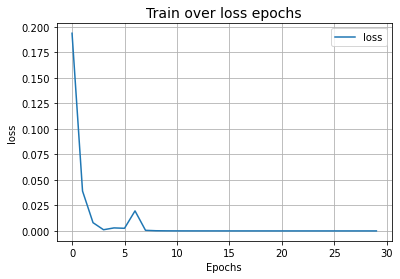

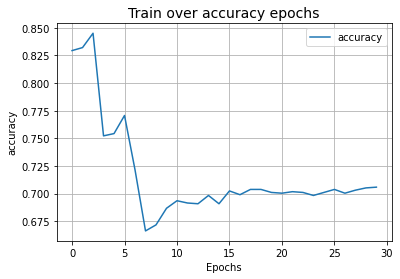

In [140]:
epochs = 30

callbacks = [
     ModelCheckpoint(check_path, monitor='accuracy', save_best_only=True, verbose=0),
]

history = model.fit(
    seq_train_df,
    params_train_binarized,
    epochs = epochs,
    batch_size=10,
    callbacks=callbacks
)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train over {} epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("accuracy")

In [141]:
_, acc = model.evaluate(seq_test_df, params_test_binarized)
print(f"Accuracy on the test set: {round(acc *100, 2)}%")

6/6 [==============================] - 2s 164ms/step - loss: 0.1018 - accuracy: 0.7607
Accuracy on the test set: 76.07%


In [5]:
model = models.load_model(check_path)

In [6]:
def preprocess_text(line):
  tokenized_string = tokenizer_text.texts_to_sequences([line])
  padded_sequence = pad_sequences(tokenized_string, maxlen=max_text_len)
  return padded_sequence


In [149]:
test_string = preprocess_text("ДН 0")
#print(test_string)
result = model.predict(tf.convert_to_tensor(test_string))
print(result)

1/1 [==============================] - 0s 47ms/step
[[2.8238720e-03 8.8604713e-07]]
